# Forecast skill analysis

This notebook presents different methods to evaluate and visualize the skill of a forecasting model.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import seaborn as sns

import modelskill as ms

sns.set_palette("Set1")

In [18]:
def path_to_file(filename):
    return f"../tests/testdata/forecast_skill/{filename}"

matched_model_results = pd.read_csv(path_to_file("matched_model_results.csv"), parse_dates=True, index_col=0)
matched_model_results.round(2).head(7)

,lead_time,model_1,model_2,observation
date,,,,
2023-01-07,1,13804.10,12663.04,14319.96
2023-01-07,2,13302.96,12898.16,14319.96
2023-01-07,3,13388.44,13505.24,14319.96
2023-01-07,4,13014.56,13444.72,14319.96
2023-01-07,5,12845.50,13086.09,14319.96
2023-01-07,6,12801.62,13413.75,14319.96
2023-01-07,7,13003.76,13204.51,14319.96


We depart from a dataframe containing matched results from two models; each model allows us to forecast the value of an arbitrary variable _X_ up to 7 days in advance. The `lead_time` column in the previous dataframe represents how many days in advance did we forecast the value of _X_. To see how to generate such dataframe, consider visiting the [data wrangling notebook](../notebooks/Forecast_data_wrangling.ipynb).

Our goal is to assess which of the two model candidates (`model_1` and `model_2`) better represent an underlying system, which we have observations from. When comparing models, we often want to have a simple benchmark model to guarantee that our candidate models represent an improvement over other naive prediction methods based on simple heuristics. For instance, a model that is commonly used as benchmark is a simple model that always returns a constant value which represents the mean of our available observations. `modelskill` provides tools to generate such a naive model by using the `DummyModelResult` class, as can be seen below.

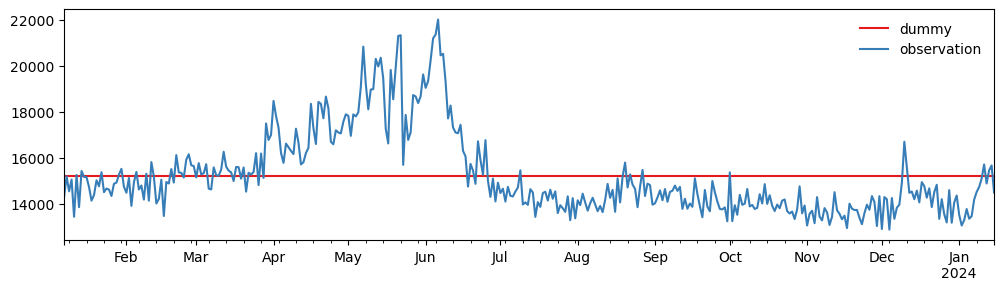

In [19]:
observations = matched_model_results["observation"].drop_duplicates().to_frame()

obs = ms.PointObservation(observations)
mr = ms.DummyModelResult(strategy='mean')
pmr = mr.extract(obs).to_dataframe()

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
pmr.merge(observations, on="time").plot(ax=ax)
ax.set_xlabel("")
ax.legend(frameon=False)
plt.show()


Now, we proceed to merge the results of this dummy model with our matched results

In [20]:
pmr.index.name = "date"
matched_model_results = matched_model_results.merge(pmr, on="date", how="inner")
matched_model_results.round(2).head(7)

,lead_time,model_1,model_2,observation,dummy
date,,,,,
2023-01-07,1,13804.10,12663.04,14319.96,15237.57
2023-01-07,2,13302.96,12898.16,14319.96,15237.57
2023-01-07,3,13388.44,13505.24,14319.96,15237.57
2023-01-07,4,13014.56,13444.72,14319.96,15237.57
2023-01-07,5,12845.50,13086.09,14319.96,15237.57
2023-01-07,6,12801.62,13413.75,14319.96,15237.57
2023-01-07,7,13003.76,13204.51,14319.96,15237.57


With the previous dataframe, it is straightforward to generate the following skill table.

Recall that we want to analyze how the models performs for different horizons (from 1 to 7 days ahead), for this reason we pass the column with the lead time as `aux_items`. Then, we can filter the results by model and by lead time.

In [21]:
cmp = ms.from_matched(matched_model_results, mod_items=["model_1", "model_2", "dummy"], aux_items=["lead_time"], obs_item="observation")

metrics = ["bias", "rmse", "mae", "mape"]
sk = cmp.skill(by=["model", "lead_time"], metrics=metrics).sort_index()
sk.round(2).style()

## Plotting skill

The results in the skill table can be directly visualized as follows:

In [22]:
def prepare_skill_table_for_plot(sk):
    skill_for_plot = sk.to_dataframe().reset_index().drop(columns=["observation", "n"])
    baseline = pd.DataFrame(
        {
            "model": ["dummy", "model_1", "model_2"],
            "lead_time": [0, 0, 0],
        }
    )
    # We add a line of zeros for viz purposes
    for metric in metrics:
        baseline[metric] = 0

    return pd.concat([skill_for_plot, baseline]).sort_values(by=["model", "lead_time"])

def plot_skill_by_lead_time(df, metric):

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    sns.lineplot(
        data=df,
        x="lead_time",
        y=metric,
        hue="model",
        ax=ax,
    )
    fig.suptitle("Skill by lead time")

    ax.set_xlabel("Lead time [days]", fontsize=12)
    ax.set_ylabel("MAPE [%]", fontsize=12)
    ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.28, 0.7)),
    ax.tick_params(axis="both", which="major", labelsize=12)

    plt.tight_layout()
    plt.show()

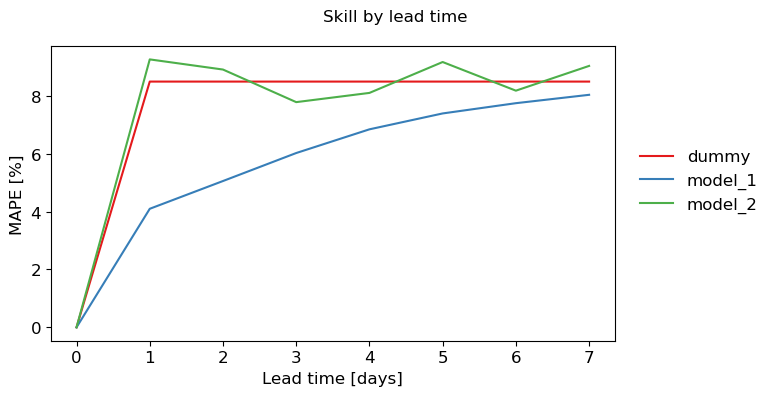

In [23]:
metric = "mape"
skill_for_plot = prepare_skill_table_for_plot(sk)

plot_skill_by_lead_time(skill_for_plot, metric)

Notice that, for the three models, we have included the skill at lead time equal to zero. In all cases, the skill has been set to zero representing that, at the time of the forecast we already observe the value of _X_, thus we have a perfect forecast.

The previous plot only shows the MAPE value for each lead time. The figure suggests that model 2 is not better than the naive dummy approach and model 1 is a clear improvement. Still, the skill of Model 1 decreases with lead time and, as the lead time gets close to 7, the three models have very similar performance. The trend in model 1 is often observed when analyzing forecasting models, as the most recent observations contain more information about future values of _X_.

### Skill as a distribution

The results in the previous section aggregate the skill of the different models into one single value per lead time, however, we might be interested in how the skill is distributed per lead time. In order to do this, we go back to the raw dataframe and create three different columns: `error`, `absolute_error` and `percentage_error`.

In [24]:
def generate_melted_error_df(matched_results):
    melted_model_results = pd.melt(matched_results.reset_index(), id_vars=["time", "lead_time", "observation"], var_name="model")

    melted_model_results["error"] = melted_model_results["observation"] - melted_model_results["value"]
    melted_model_results["absolute_error"] = abs(melted_model_results["error"])
    melted_model_results["percentage_error"] = 100 * melted_model_results["absolute_error"] / melted_model_results["observation"]

    return melted_model_results

With these newly created columns, we can evaluate how these errors are distributed for each model and lead time.

In [25]:
def plot_error_distribution_array(mmr):

    def plot_skill_quantile_by_leadtime(df, ax):
        for interval in [25, 50, 75]:
            sns.lineplot(
                df,
                x="lead_time",
                y="percentage_error",
                estimator="median",
                errorbar=("pi", interval),
                hue="model",
                ax=ax,
                linewidth=2.5,
                err_kws=dict(linewidth=0, alpha=0.15)
            )
        
        ax.legend([], [], frameon=False)
        ax.set_xlabel("Lead time [days]", fontsize=12)
        ax.set_ylabel(ylabel_dict[errorcol], fontsize=12)

    def plot_model_comparison_with_violinplot(df, ax):
        sns.violinplot(
            data=df,
            x="lead_time",
            y=errorcol,
            hue="model",
            split=True,
            gap=0.15,
            inner="quarts",
            ax=ax,
            alpha=0.9,
            saturation=0.7,
            bw_adjust=0.6,
            common_norm=True,
            density_norm="area",
            cut=0,
        )
        ax.spines[['right', 'top']].set_visible(False)
        ax.legend(frameon=False, ncols = 2)
        ax.set_xlabel("")
        ax.set_ylabel("")

    def create_empty_plot_with_legend(ax):

        rectangle_color = sns.color_palette().as_hex()[0]
        rect1 = Patch(facecolor=rectangle_color, alpha=0.45, label='25%')
        rect2 = Patch(facecolor=rectangle_color, alpha=0.30, label='50%')
        rect3 = Patch(facecolor=rectangle_color, alpha=0.15, label='75%')
        line = Line2D([0], [0], color=rectangle_color, label='Median')
        ax.legend(handles=[rect1, rect2, rect3, line], loc='upper right', title='Error quantiles:', frameon=False)
        ax.set_axis_off()

    ylabel_dict = {"error": "Error", "absolute_error": "Absolute error", "percentage_error": "Percentage error [%]"}
    errorcol = "percentage_error"

    models = mmr["model"].unique().tolist()

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for i, model_i in enumerate(models):

        df_ii = mmr.loc[mmr["model"] == model_i, :].copy()

        plot_skill_quantile_by_leadtime(df_ii, axes[i, i])
        axes[i, i].tick_params(axis="both", which="major", labelsize=12)
        axes[i, i].set_xlim(1, 7)
        axes[i, i].set_ylim(0, 20)

        other_models = [m for m in models if m != model_i]
        for model_j in other_models:
            j = models.index(model_j)
            if j > i:
                comb = (model_i, model_j)
                df_ij = mmr.loc[mmr["model"].isin(comb), :].copy()
                plot_model_comparison_with_violinplot(df_ij, axes[i, j])
            elif j == (i-1):
                create_empty_plot_with_legend(axes[i, j])  
            else:
                axes[i, j].set_axis_off()
        
            axes[i, j].tick_params(axis="both", which="major", labelsize=12)


    plt.tight_layout()
    plt.show()

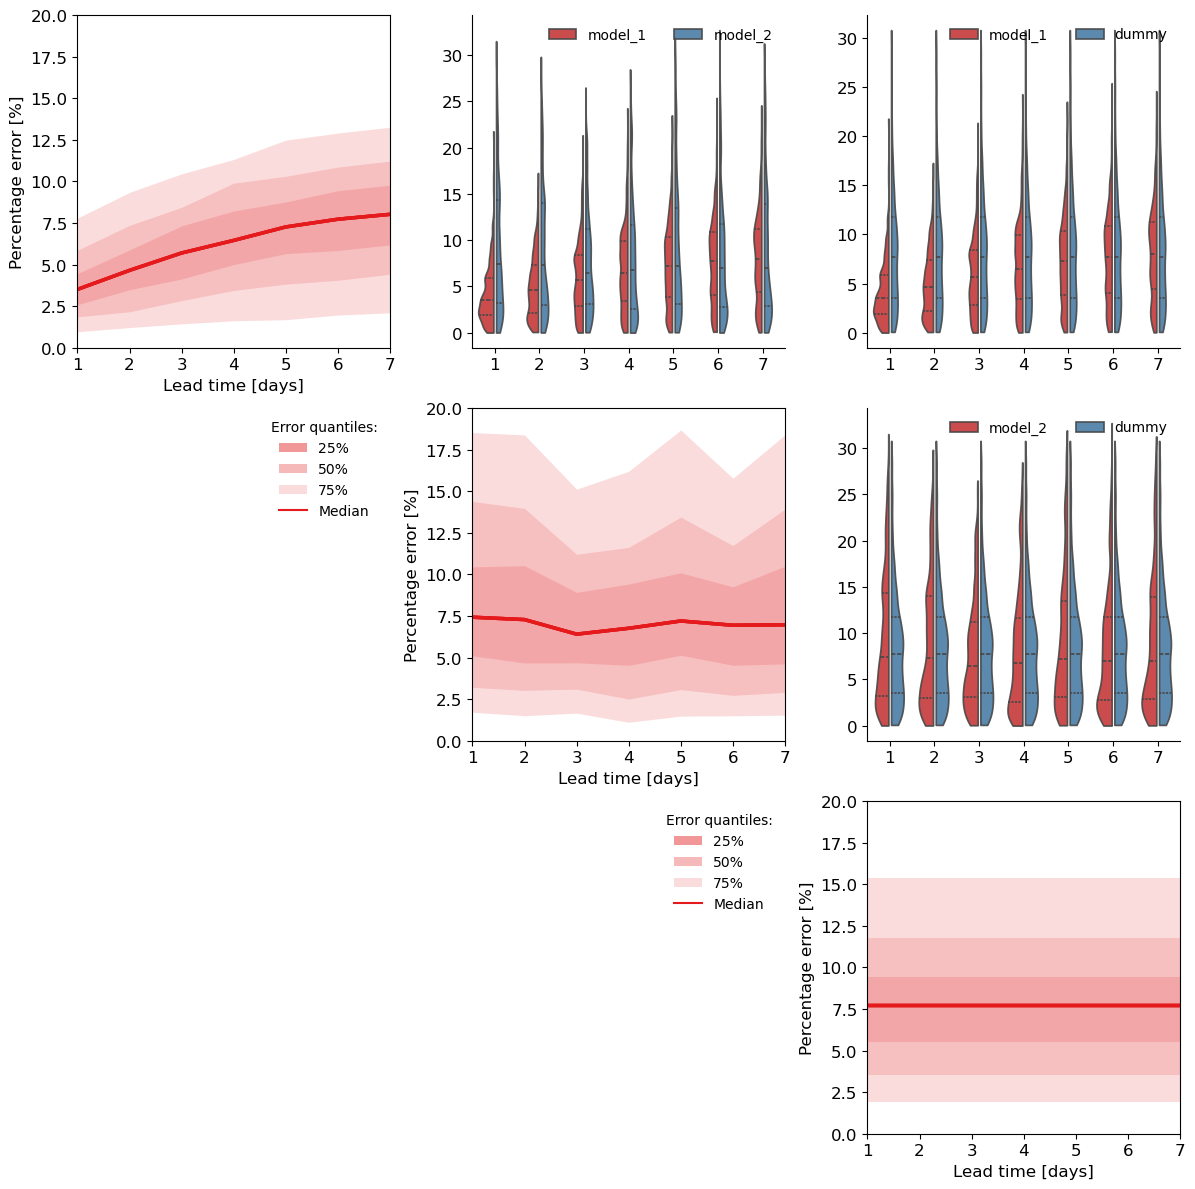

In [26]:
melted_results = generate_melted_error_df(matched_model_results)
plot_error_distribution_array(melted_results)

The previous image shows how the errors are spread at different horizons. In addition, the models are compared in the upper right subplots. It is easy to see that model 2 presents a wider distribution of errors, even though the median is low enough. This results highlights that model 2 significanlty misses the target more often than model 1.

This results can be further validated looking at the violin plots, where it can be seen how the distribution of errros from model 2 always hase a longer tail than model 1 errors. Interestingly, it can be noted that, even though model 2 distribution is wider than model 1, after lead time equal to 5 there is a shift and the median of errors is slightly lower in model 2 compared to model 1.

### Focused skill

All previous results have been computed using all available data. However, there might be periods where the skill assessment is more important than others. For example, let´s assume it is particularly critical that our model has a good performance when the value of _X_ is above a certain threshold.

In [27]:
threshold = 14000
skill_high_values = cmp.where(cmp.data.Observation > threshold).skill(by=["model", "lead_time"], metrics=metrics).sort_index()

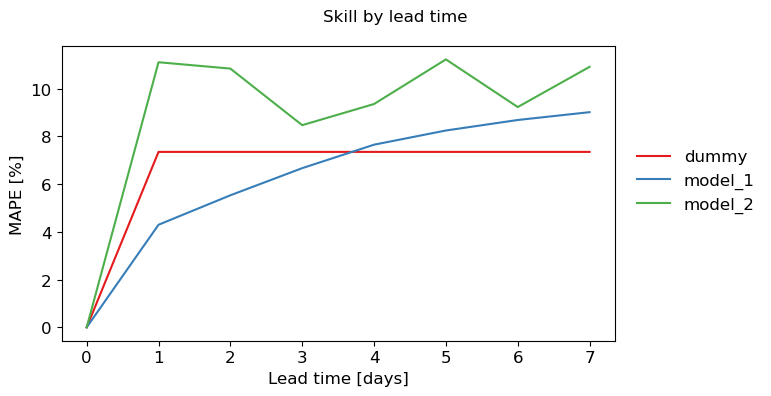

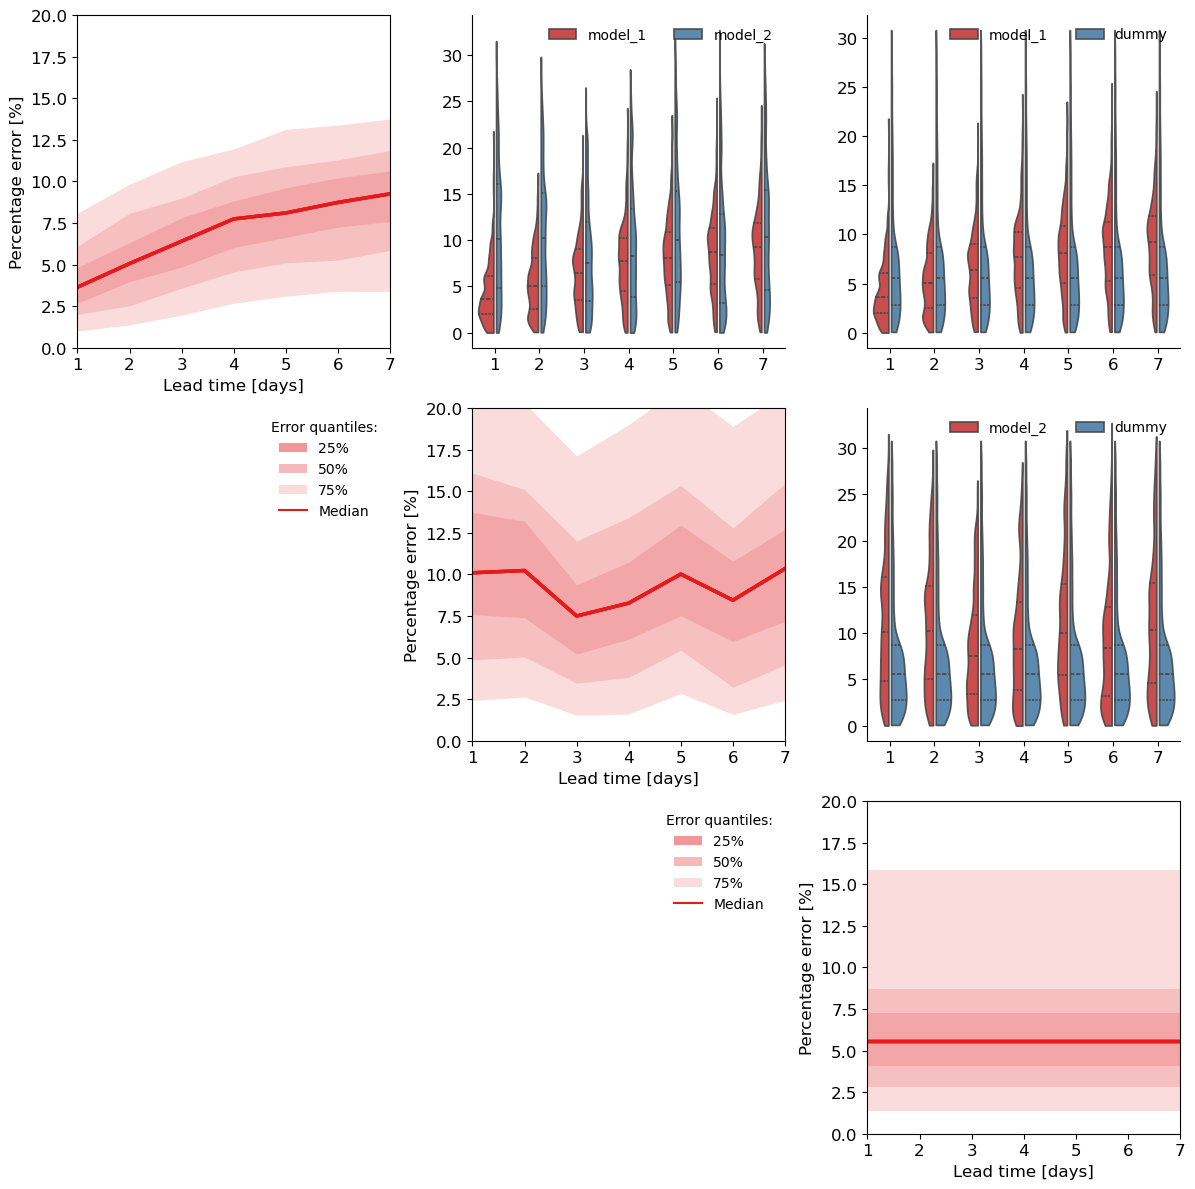

In [28]:
skill_for_plot = prepare_skill_table_for_plot(skill_high_values)
plot_skill_by_lead_time(skill_for_plot, metric)

filtered_matched_results = matched_model_results.loc[matched_model_results["observation"] > threshold,:].copy()
melted_results = generate_melted_error_df(filtered_matched_results)
plot_error_distribution_array(melted_results)

In this case, we observe that, compared to the dummy model, model 1 underperforms for longer lead times. Still, the tails of model 1 distribution is always the shortest. Depending on the application we might want to go back to improving model 1 to ensure a better performance for all horizons.